In [23]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def tsplot(y, lags=15):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # layout
    fig = plt.figure(figsize=(14, 6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    # ts plot
    y.plot(ax=ts_ax)
    ts_ax.set_title('Time series');
    
    # acf, pacf
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    plt.show()

# Téma 3: ACF, PACF, autoregresní modely

## Korelační koeficient (lineární, též Pearsonův)

Mějme dvě náhodné veličiny $X$ a $Y$, obě s kladnými a konečnými druhými momenty - variancemi - $\sigma_X^2$ a $\sigma_Y^2$ a s kovariancí $\operatorname{cov}(X, Y) = \sigma_{XY}$. Lineární (též Pearsonův) korelační koeficient definujeme jako

$$
r_{XY} = \frac{\mathbb{E}[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X\sigma_Y} = \frac{\sigma_{XY}}{\sigma_X \sigma_Y^2}, \qquad r \in [-1, 1].
$$

Lineární korelační koeficient $r_{XY}$ označuje míru lineární závislosti obou veličin. Pokud jsou veličiny $X$ a $Y$ **nezávislé**, pak $r_{XY} = 0$. Pozor, je snadné dokázat, že **opačné tvrzení neplatí**! Jsou-li veličiny přesně lineárně závislé, pak $r_{XY} = \pm 1$ podle toho, zda je mezi nimi úměra přímá či nikoliv. To jest, pokud $Y=aX + b$ a $a>0$, je $r_{XY} = 1$, pokud $a<0$, je $r_{XY}=-1$. Pokud není jedna veličina deterministicky vysvětlována druhou, tj. je přítomen šum, je hodnota koeficientu v intervalu $(-1, 1)$. V každém případě je nutno brát v potaz lineární vztah mezi proměnnými! Více viz obrázek z wikipedie.
![corrcoef](img/corrwiki.png)

**Výběrový korelační koeficient** můžeme spočítat např. podle vzorce

$$
r = r_{xy} = \frac{1}{n-1} \sum_{i=1}^{n} 
\left( \frac{x_i - \bar{x}}{s_x} \right)
\left( \frac{y_i - \bar{y}}{s_y} \right),
$$

kde $\bar{x}, \bar{y}$ jsou průměry a $\sigma_x, \sigma_y$ směrodatné odchylky příslušných veličin. 

**K zamyšlení**

- jak souvisí korelační koeficient s regresí pomocí přímky?
- ve stejném případě - je nějaký vztah mezi korelačním koeficientem a koeficientem determinace v regresi?


## Parciální korelační koeficient

Mějme dvě náhodné veličiny $X$ a $Y$, mezi nimiž existuje nějaká lineární závislost, ovšem obě jsou ovlivněny ještě třetí $n$-rozměrnou náhodnou veličinou (vektorem) $Z$. Pokud chceme nyní měřit korelaci mezi $X$ a $Y$, je potřeba je od vlivu $Z$ očistit. To lze udělat tak, že nalezneme regresní přímky

$$
\begin{aligned}
\hat{X} &= a + b^\intercal Z, \\
\hat{Y} &= c + d^\intercal Z.
\end{aligned}
$$

Veličiny $\hat{X}$ a $\hat{Y}$ jsou tedy nejlepším lineárním přiblížením k veličinám $X$ a $Y$ a současně s tím jsou veličiny $e_X = (X-\hat{X})$ a $e_Y = (Y-\hat{Y})$ očištěny od vlivu $Z$, neboť jde o rezidua, jež $Z$ nevysvětlila. Jejich korelační koeficient nazýváme **parciální korelační koeficient mezi $X$ a $Y$ při daném $Z$**, značíme jej $r_{XY\cdot Z}$ a počítáme podle vztahu

$$
r_{XY\cdot Z} =
\frac
{r_{XY} - \operatorname{cor}(X,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,Y)}
{\sqrt{
\left[ 1 - \operatorname{cor}(X,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,X) \right]
\left[ 1 - \operatorname{cor}(Y,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,Y) \right]
}},
$$

kde $\operatorname{cor}(X, Z)= (r_{X,z_i})$ značí korelační matici pro veličinu $X$ a vektor $Z$ (analogicky pro $Y$ a $Z$) a $\operatorname{cor}(Z)=(r_{z_i,z_j})$ je korelační matice prvků $Z$. Pokud je $Z$ skalární, potom dostaneme mnohem jednodušší výraz

$$
r_{XY\cdot Z} = \frac
{r_{XY} - r_{ZX}r_{ZY}}
{\sqrt{\left(1-r_{ZX}^2\right)\left(1-r_{ZY}^2\right)}}.
$$

**K zamyšlení**

- jaké hodnoty má parciální korelační koeficient?
- jak vypadají data, pokud je parciální korelační koeficient roven jedné?
- jaké vlastnosti má korelační matice? Jaké hodnoty mají prvky, diagonála, jak je to se symetrií?

## Autokorelace, ACF (autocorrelation function)

Ve statistice autokorelační koeficient označuje lineární (Pearsonovu) korelaci hodnot časové řady v různých časových okamžicích. To umožňuje odhalit opakující se vývoj řady.

> Buď $\{X_t, t=1,2,\ldots\}$ časová řada se střední hodnotou $\mu_t$ a variancí $\sigma_t^2$ pro každé $t$. Autokorelační koeficient pro časy $s$ a $t$ je definován jako
>
>$$
R(s,t) = \frac{\mathbb{E}[(X_t-\mu_t)(X_s - \mu_s)]}{\sigma_t\sigma_s}, \qquad R(s,t) \in [-1, 1],
$$
>
> za podmínky, že příslušné střední hodnoty a rozptyly existují a jsou kladné.

Pokud je $\{X_t, t=1,2\ldots\}$ slabě stacionární proces, tedy existují časově invariantní první dva momenty $\mu$ a $\sigma^2$, potom autokorelace závisí pouze na zpoždění mezi $t$ a $s$,

$$
R(s, t) = R(s-t) = R(\tau) = \frac{\mathbb{E}[(X_t-\mu)(X_{t+\tau}-\mu]}{\sigma^2}, \qquad \tau=s-t,
$$

a $R(\tau) = R(-\tau)$.

Výběrový autokorelační koeficient slabě stacionárního procesu se známými $\mu$ a $\sigma^2$ a s pozorováními $\{x_1, \ldots, x_n\}$ pro čas $k<n$ spočítáme jako

$$
\widehat{R}(k) = \frac{1}{(n-k)} \sum_{t=1}^{n-k} \frac{(x_t - \mu)(x_{t+k} - \mu)}{\sigma^2}.
$$

Pokud střední hodnotu ani rozptyl neznáme, použijeme jejich výběrové odhady.

## Parciální autokorelační funkce (PACF)

Mějme opět časovou řadu $\{X_t\}$. Parciální autokorelace zpoždění $k \geq 1$, značená $\alpha(k)$, je (auto)korelace mezi $X_t$ a $X_{t+k}$ s odstraněním lineárního vlivu mezilehlých hodnot $X_{t+1},\ldots, X_{t+k-1}$, tedy

$$
\alpha(k) = r_{X_{t+k}X_{t}\cdot \{X_{t+1},\ldots,X_{t+k-1}\}}.
$$

Hodnoty PACF se obvykle odhadují z výběrové autokorelace.

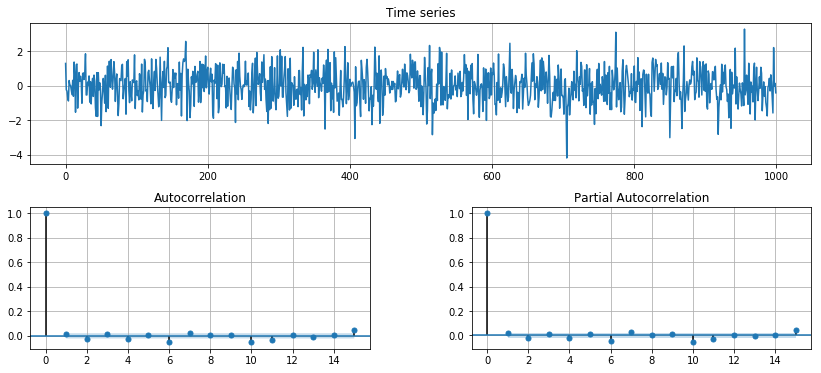

In [24]:
x = np.random.normal(size=1000)
tsplot(x)

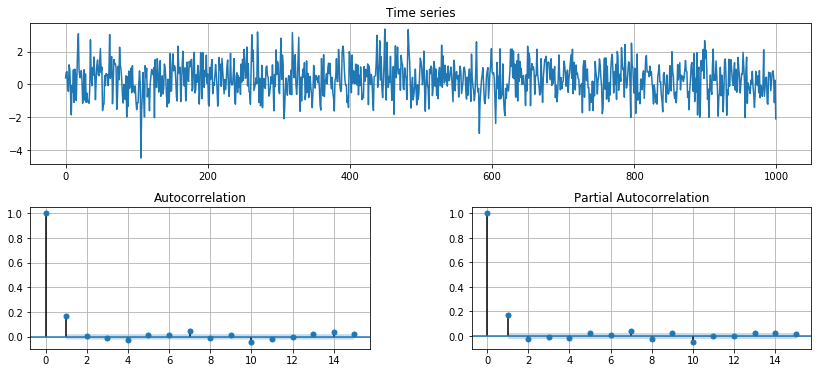

In [32]:
ndat = 1000
x = np.zeros(ndat)
x[0] = 0.4
for i in range(1, ndat):
    x[i] = .3 + .2*x[i-1] + np.random.normal()
tsplot(x)

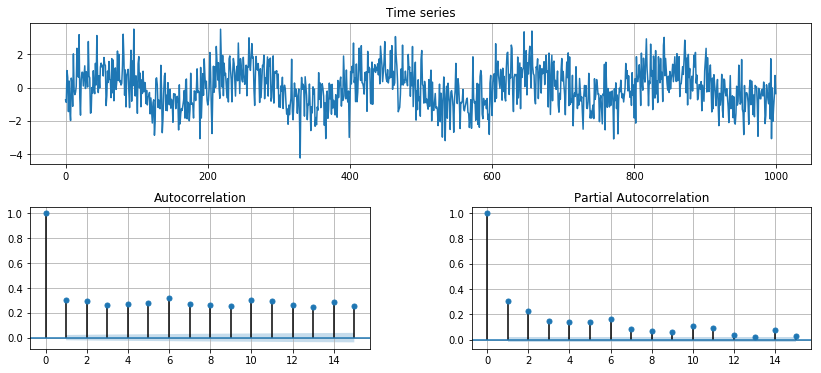

In [42]:
x = np.sin(np.linspace(0, 10*np.pi, 1000)) + np.random.normal(size=1000)
tsplot(x)

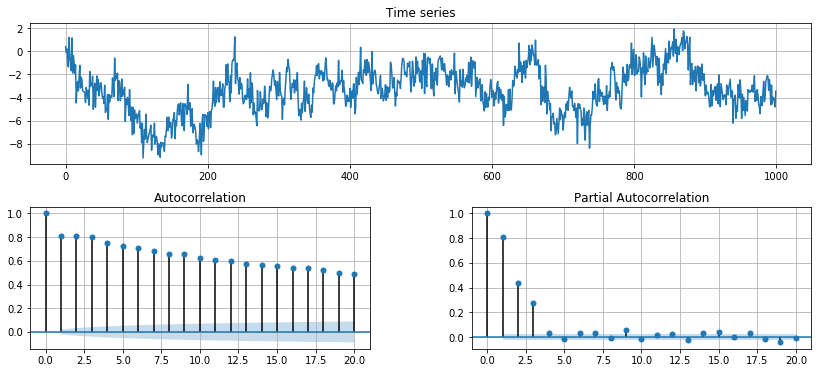

In [40]:
ndat = 1000
x = np.zeros(ndat)
x[0] = .4
x[1] = -.1
x[2] = .2
for i in range(3, ndat):
    x[i] = -.3 + .3*x[i-1] + .3*x[i-2] + .3*x[i-3] + np.random.normal()
tsplot(x, lags=20)

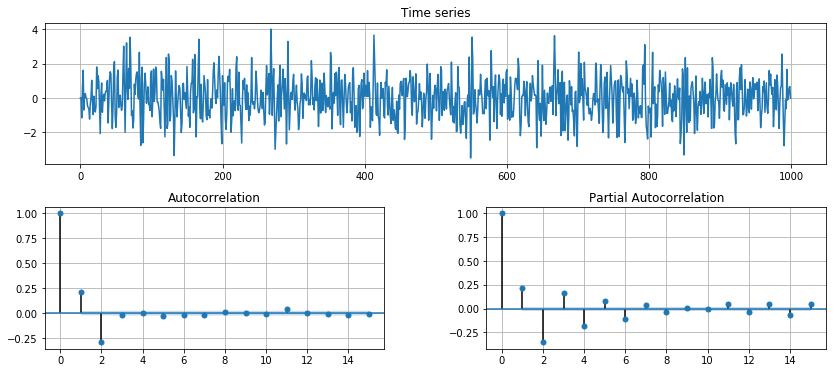

In [45]:
ndat = 1000
epsilon = np.random.normal(size=ndat)
x = np.zeros(ndat)
mean = 0
for t in range(2, ndat):
    x[t] = mean + epsilon[t] + .4*epsilon[t-1] - .3*epsilon[t-2]
tsplot(x)